In [1]:
# Imports dan paths

import pandas as pd, numpy as np, optuna, mlflow, xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from pathlib import Path

/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
DAILY_PARQUET = Path("../data/processed/daily_features.parquet")
df_daily = pd.read_parquet(DAILY_PARQUET)
df_daily.head()

,station_id,date_local,temp_13LT_C,rh_avg_pc,wind_avg_kmh,qff_avg_hPa,rain_mm,evap_mm,ffmc
0,96595,2015-01-01 00:00:00+00:00,32.2,71.39375,0.92600,1009.58750,3.0,4.0,73.688695
1,96595,2015-01-02 00:00:00+00:00,30.0,79.08750,0.92600,1010.58125,0.0,3.0,83.174782
2,96595,2015-01-03 00:00:00+00:00,31.1,79.30000,0.00000,1010.85625,0.0,3.0,84.831423
3,96595,2015-01-04 00:00:00+00:00,30.9,76.87500,1.15750,1009.85000,20.5,6.0,60.330249
4,96595,2015-01-05 00:00:00+00:00,29.2,85.48750,0.57875,1010.38750,10.8,6.0,58.220215


In [4]:
df_daily["date_local"] = pd.to_datetime(df_daily["date_local"])

In [5]:
### Feature engineering – lags, rolling means, DOY encodings
LAGS  = [1, 3]
ROLLS = [3, 7]

df = df_daily.sort_values(["station_id", "date_local"]).set_index("date_local")

for col in ["temp_13LT_C", "rh_avg_pc", "wind_avg_kmh",
            "qff_avg_hPa", "rain_mm", "evap_mm"]:
    for k in LAGS:
        df[f"{col}_lag{k}"] = df.groupby("station_id")[col].shift(k)
    for w in ROLLS:
        df[f"{col}_roll{w}"] = (
            df.groupby("station_id")[col]
              .rolling(w, min_periods=1).mean()
              .droplevel(0)
        )

df["doy_sin"] = np.sin(2*np.pi*df.index.dayofyear / 365.25)
df["doy_cos"] = np.cos(2*np.pi*df.index.dayofyear / 365.25)
df["month"]   = df.index.month

# drop first-lag rows that now contain NaN
df = df.dropna(subset=[c for c in df.columns if "lag" in c]).reset_index()
df.head()


,date_local,station_id,temp_13LT_C,rh_avg_pc,wind_avg_kmh,qff_avg_hPa,rain_mm,evap_mm,ffmc,temp_13LT_C_lag1,temp_13LT_C_lag3,temp_13LT_C_roll3,temp_13LT_C_roll7,rh_avg_pc_lag1,rh_avg_pc_lag3,rh_avg_pc_roll3,rh_avg_pc_roll7,wind_avg_kmh_lag1,wind_avg_kmh_lag3,wind_avg_kmh_roll3,wind_avg_kmh_roll7,qff_avg_hPa_lag1,qff_avg_hPa_lag3,qff_avg_hPa_roll3,qff_avg_hPa_roll7,rain_mm_lag1,rain_mm_lag3,rain_mm_roll3,rain_mm_roll7,evap_mm_lag1,evap_mm_lag3,evap_mm_roll3,evap_mm_roll7,doy_sin,doy_cos,month
0,2015-01-04 00:00:00+00:00,96595,30.9,76.87500,1.15750,1009.85000,20.5,6.0,60.330249,31.1,32.2,30.666667,31.050000,79.30000,71.39375,78.420833,76.664062,0.00000,0.92600,0.694500,0.752375,1010.85625,1009.58750,1010.429167,1010.218750,0.0,3.0,6.833333,5.875000,3.0,4.0,4.000000,4.000000,0.068755,0.997634,1
1,2015-01-05 00:00:00+00:00,96595,29.2,85.48750,0.57875,1010.38750,10.8,6.0,58.220215,30.9,30.0,30.400000,30.680000,76.87500,79.08750,80.554167,78.428750,1.15750,0.92600,0.578750,0.717650,1009.85000,1010.58125,1010.364583,1010.252500,20.5,0.0,10.433333,6.860000,6.0,3.0,5.000000,4.400000,0.085906,0.996303,1
2,2015-01-06 00:00:00+00:00,96595,30.0,82.90625,1.50475,1009.46250,32.5,6.0,60.075054,29.2,31.1,30.033333,30.566667,85.48750,79.30000,81.756250,79.175000,0.57875,0.00000,1.080333,0.848833,1010.38750,1010.85625,1009.900000,1010.120833,10.8,0.0,21.266667,11.133333,6.0,3.0,6.000000,4.666667,0.103031,0.994678,1
3,2015-01-07 00:00:00+00:00,96595,27.2,88.31875,2.08350,1010.45625,19.7,4.0,56.740650,30.0,30.9,28.800000,30.085714,82.90625,76.87500,85.570833,80.481250,1.50475,1.15750,1.389000,1.025214,1009.46250,1009.85000,1010.102083,1010.168750,32.5,20.5,21.000000,12.357143,6.0,6.0,5.333333,4.571429,0.120126,0.992759,1
4,2015-01-08 00:00:00+00:00,96595,28.6,84.60625,1.15750,1010.61250,6.3,4.0,62.820614,27.2,29.2,28.600000,29.571429,88.31875,85.48750,85.277083,82.368750,2.08350,0.57875,1.581917,1.058286,1010.45625,1010.38750,1010.177083,1010.315179,19.7,10.8,19.500000,12.828571,4.0,6.0,4.666667,4.571429,0.137185,0.990545,1


In [11]:
###  NEW – station-stratified random split

from sklearn.utils import shuffle

test_frac = 0.20
test_idx  = (
    df.groupby('station_id', group_keys=False)
      .apply(lambda g: g.sample(frac=test_frac, random_state=42))
      .index
)

train_idx = df.index.difference(test_idx)

train = df.loc[train_idx].copy()
test  = df.loc[test_idx].copy()

PRED_COLS = [c for c in df.columns if c not in ('station_id', 'ffmc', 'date_local')]
X_train, y_train = train[PRED_COLS], train['ffmc']
X_test,  y_test  = test[PRED_COLS],  test['ffmc']
print(f"Train rows: {len(train):,}  |  Test rows: {len(test):,}")


Train rows: 13,095  |  Test rows: 3,273


/tmp/ipykernel_4426/973251534.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=test_frac, random_state=42))


In [12]:
### Optuna + MLflow tuning – find best XGBoost hyper-params
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("ffmc_xgb")

def objective(trial):
    params = {
        "n_estimators"     : trial.suggest_int("n_estimators", 300, 1200),
        "max_depth"        : trial.suggest_int("max_depth", 3, 10),
        "learning_rate"    : trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample"        : trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "random_state"     : 42,
        "n_jobs"           : -1,
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))

    with mlflow.start_run():
        mlflow.log_params(params)
        mlflow.log_metric("rmse", rmse)
        mlflow.xgboost.log_model(model, "model")
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, show_progress_bar=True)

best_rmse = study.best_value
print("Best RMSE:", best_rmse)


[I 2025-06-21 22:02:10,360] A new study created in memory with name: no-name-8dcf97e0-cf21-493a-a43a-87a0937a4398
  0%|          | 0/40 [00:00<?, ?it/s]2025/06/21 22:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:02:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:02:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 0. Best value: 0.440238:   2%|▎         | 1/40 [00:03<02:08,  3.29s/it]

[I 2025-06-21 22:02:13,646] Trial 0 finished with value: 0.4402377367859698 and parameters: {'n_estimators': 945, 'max_depth': 3, 'learning_rate': 0.02300088277803527, 'subsample': 0.8019758237087207, 'colsample_bytree': 0.9210300499235712}. Best is trial 0 with value: 0.4402377367859698.


2025/06/21 22:02:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:02:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:02:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 0. Best value: 0.440238:   5%|▌         | 2/40 [00:05<01:43,  2.73s/it]

[I 2025-06-21 22:02:15,985] Trial 1 finished with value: 1.598438760843147 and parameters: {'n_estimators': 310, 'max_depth': 3, 'learning_rate': 0.010337601420241104, 'subsample': 0.9606638518621762, 'colsample_bytree': 0.6301178410721485}. Best is trial 0 with value: 0.4402377367859698.


2025/06/21 22:02:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:02:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:02:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 0. Best value: 0.440238:   8%|▊         | 3/40 [00:16<04:03,  6.57s/it]

[I 2025-06-21 22:02:27,128] Trial 2 finished with value: 0.6511669007341603 and parameters: {'n_estimators': 1023, 'max_depth': 8, 'learning_rate': 0.09617843203987411, 'subsample': 0.8919304269158472, 'colsample_bytree': 0.8252709190974631}. Best is trial 0 with value: 0.4402377367859698.


2025/06/21 22:02:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:02:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:02:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 3. Best value: 0.412455:  10%|█         | 4/40 [00:22<03:48,  6.35s/it]

[I 2025-06-21 22:02:33,129] Trial 3 finished with value: 0.41245508849128326 and parameters: {'n_estimators': 443, 'max_depth': 8, 'learning_rate': 0.031346089884453116, 'subsample': 0.7235406102129921, 'colsample_bytree': 0.9737908009041494}. Best is trial 3 with value: 0.41245508849128326.


2025/06/21 22:02:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:02:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:02:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 3. Best value: 0.412455:  12%|█▎        | 5/40 [00:36<05:13,  8.97s/it]

[I 2025-06-21 22:02:46,741] Trial 4 finished with value: 0.6498907042416645 and parameters: {'n_estimators': 868, 'max_depth': 10, 'learning_rate': 0.10395760728589482, 'subsample': 0.8519313528227683, 'colsample_bytree': 0.8684248074940566}. Best is trial 3 with value: 0.41245508849128326.


2025/06/21 22:02:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:02:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:02:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 3. Best value: 0.412455:  15%|█▌        | 6/40 [00:42<04:29,  7.94s/it]

[I 2025-06-21 22:02:52,684] Trial 5 finished with value: 0.44045017952661114 and parameters: {'n_estimators': 718, 'max_depth': 7, 'learning_rate': 0.051206057111806313, 'subsample': 0.7724969497527315, 'colsample_bytree': 0.8921913581937533}. Best is trial 3 with value: 0.41245508849128326.


2025/06/21 22:02:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:02:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:02:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 6. Best value: 0.406815:  18%|█▊        | 7/40 [00:46<03:39,  6.65s/it]

[I 2025-06-21 22:02:56,688] Trial 6 finished with value: 0.406815472274921 and parameters: {'n_estimators': 1055, 'max_depth': 5, 'learning_rate': 0.08633319581458172, 'subsample': 0.8995238885367468, 'colsample_bytree': 0.9150357547072223}. Best is trial 6 with value: 0.406815472274921.


2025/06/21 22:03:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:03:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:03:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 6. Best value: 0.406815:  20%|██        | 8/40 [00:52<03:31,  6.61s/it]

[I 2025-06-21 22:03:03,191] Trial 7 finished with value: 0.6315754447736782 and parameters: {'n_estimators': 877, 'max_depth': 7, 'learning_rate': 0.21105844380386835, 'subsample': 0.7900770516983461, 'colsample_bytree': 0.6989660972278162}. Best is trial 6 with value: 0.406815472274921.


2025/06/21 22:03:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:03:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:03:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 6. Best value: 0.406815:  22%|██▎       | 9/40 [00:56<02:56,  5.70s/it]

[I 2025-06-21 22:03:06,918] Trial 8 finished with value: 0.5395696682969158 and parameters: {'n_estimators': 583, 'max_depth': 6, 'learning_rate': 0.022698808649498914, 'subsample': 0.9434186650285841, 'colsample_bytree': 0.658246082032134}. Best is trial 6 with value: 0.406815472274921.


2025/06/21 22:03:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:03:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:03:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 6. Best value: 0.406815:  25%|██▌       | 10/40 [01:07<03:42,  7.42s/it]

[I 2025-06-21 22:03:18,164] Trial 9 finished with value: 1.0286567989187796 and parameters: {'n_estimators': 427, 'max_depth': 10, 'learning_rate': 0.03863720668741796, 'subsample': 0.6634122018118543, 'colsample_bytree': 0.656468054497258}. Best is trial 6 with value: 0.406815472274921.


2025/06/21 22:03:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:03:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:03:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 6. Best value: 0.406815:  28%|██▊       | 11/40 [01:11<03:04,  6.38s/it]

[I 2025-06-21 22:03:22,181] Trial 10 finished with value: 0.5443057887829242 and parameters: {'n_estimators': 1182, 'max_depth': 5, 'learning_rate': 0.24719406311462244, 'subsample': 0.9812411273090329, 'colsample_bytree': 0.7471841507998187}. Best is trial 6 with value: 0.406815472274921.


2025/06/21 22:03:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:03:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:03:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 11. Best value: 0.405327:  30%|███       | 12/40 [01:16<02:39,  5.71s/it]

[I 2025-06-21 22:03:26,381] Trial 11 finished with value: 0.4053270998821499 and parameters: {'n_estimators': 605, 'max_depth': 5, 'learning_rate': 0.0946048894881055, 'subsample': 0.6617403577301361, 'colsample_bytree': 0.9925481052072457}. Best is trial 11 with value: 0.4053270998821499.


2025/06/21 22:03:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:03:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:03:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 11. Best value: 0.405327:  32%|███▎      | 13/40 [01:19<02:16,  5.05s/it]

[I 2025-06-21 22:03:29,901] Trial 12 finished with value: 0.4064387696528033 and parameters: {'n_estimators': 686, 'max_depth': 5, 'learning_rate': 0.10259409927440298, 'subsample': 0.6394475487288314, 'colsample_bytree': 0.9916654810634112}. Best is trial 11 with value: 0.4053270998821499.


2025/06/21 22:03:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:03:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:03:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 11. Best value: 0.405327:  35%|███▌      | 14/40 [01:22<01:55,  4.45s/it]

[I 2025-06-21 22:03:32,969] Trial 13 finished with value: 0.4317749042540992 and parameters: {'n_estimators': 688, 'max_depth': 4, 'learning_rate': 0.14199969665071766, 'subsample': 0.6083177051675281, 'colsample_bytree': 0.9985937850350113}. Best is trial 11 with value: 0.4053270998821499.


2025/06/21 22:03:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:03:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:03:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 14. Best value: 0.397174:  38%|███▊      | 15/40 [01:25<01:42,  4.10s/it]

[I 2025-06-21 22:03:36,261] Trial 14 finished with value: 0.3971742581310959 and parameters: {'n_estimators': 614, 'max_depth': 5, 'learning_rate': 0.06708850155785212, 'subsample': 0.601127238548299, 'colsample_bytree': 0.9577226371227134}. Best is trial 14 with value: 0.3971742581310959.


2025/06/21 22:03:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:03:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:03:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 14. Best value: 0.397174:  40%|████      | 16/40 [01:28<01:30,  3.79s/it]

[I 2025-06-21 22:03:39,324] Trial 15 finished with value: 0.45224705012178834 and parameters: {'n_estimators': 565, 'max_depth': 4, 'learning_rate': 0.16763231696193961, 'subsample': 0.6906124833723051, 'colsample_bytree': 0.9443937604352131}. Best is trial 14 with value: 0.3971742581310959.


2025/06/21 22:03:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:03:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:03:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 14. Best value: 0.397174:  42%|████▎     | 17/40 [01:33<01:31,  3.96s/it]

[I 2025-06-21 22:03:43,689] Trial 16 finished with value: 0.46953529804377964 and parameters: {'n_estimators': 581, 'max_depth': 6, 'learning_rate': 0.06272900067570604, 'subsample': 0.6038810240970335, 'colsample_bytree': 0.83669565659773}. Best is trial 14 with value: 0.3971742581310959.


2025/06/21 22:03:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:03:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:03:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  45%|████▌     | 18/40 [01:36<01:21,  3.72s/it]

[I 2025-06-21 22:03:46,849] Trial 17 finished with value: 0.3939307350706409 and parameters: {'n_estimators': 802, 'max_depth': 4, 'learning_rate': 0.06256172580567487, 'subsample': 0.7134563322256743, 'colsample_bytree': 0.9509777334397322}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:03:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:03:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:03:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  48%|████▊     | 19/40 [01:39<01:16,  3.65s/it]

[I 2025-06-21 22:03:50,330] Trial 18 finished with value: 0.4274777720849897 and parameters: {'n_estimators': 854, 'max_depth': 4, 'learning_rate': 0.05654939117448689, 'subsample': 0.7306248759595655, 'colsample_bytree': 0.767817890751988}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:03:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:03:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:03:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  50%|█████     | 20/40 [01:42<01:07,  3.37s/it]

[I 2025-06-21 22:03:53,054] Trial 19 finished with value: 0.44435947268361214 and parameters: {'n_estimators': 773, 'max_depth': 3, 'learning_rate': 0.03958521499337667, 'subsample': 0.7376479562427686, 'colsample_bytree': 0.8675943683332069}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:03:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:03:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:03:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  52%|█████▎    | 21/40 [01:45<01:02,  3.28s/it]

[I 2025-06-21 22:03:56,122] Trial 20 finished with value: 0.48289162202754166 and parameters: {'n_estimators': 472, 'max_depth': 4, 'learning_rate': 0.014720730101023401, 'subsample': 0.687518207935879, 'colsample_bytree': 0.9350353842857891}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:03:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:03:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:03:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  55%|█████▌    | 22/40 [01:49<00:59,  3.32s/it]

[I 2025-06-21 22:03:59,525] Trial 21 finished with value: 0.40035639867176237 and parameters: {'n_estimators': 635, 'max_depth': 5, 'learning_rate': 0.07256473287051748, 'subsample': 0.654687369467611, 'colsample_bytree': 0.9567635319872466}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:04:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:04:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:04:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  57%|█████▊    | 23/40 [01:53<01:03,  3.74s/it]

[I 2025-06-21 22:04:04,245] Trial 22 finished with value: 0.4171789044300406 and parameters: {'n_estimators': 784, 'max_depth': 6, 'learning_rate': 0.07343446487225237, 'subsample': 0.6351314295578804, 'colsample_bytree': 0.9598926311422034}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:04:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:04:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:04:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  60%|██████    | 24/40 [01:57<00:57,  3.60s/it]

[I 2025-06-21 22:04:07,531] Trial 23 finished with value: 0.45204627573536543 and parameters: {'n_estimators': 651, 'max_depth': 5, 'learning_rate': 0.13391176749809167, 'subsample': 0.6926639965664342, 'colsample_bytree': 0.8935590653807971}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:04:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:04:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:04:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  62%|██████▎   | 25/40 [02:00<00:54,  3.61s/it]

[I 2025-06-21 22:04:11,166] Trial 24 finished with value: 0.39901979333626475 and parameters: {'n_estimators': 767, 'max_depth': 4, 'learning_rate': 0.04079768223632243, 'subsample': 0.6248656872946936, 'colsample_bytree': 0.941023767180985}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:04:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:04:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:04:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  65%|██████▌   | 26/40 [02:03<00:48,  3.45s/it]

[I 2025-06-21 22:04:14,248] Trial 25 finished with value: 0.43096058804023496 and parameters: {'n_estimators': 795, 'max_depth': 4, 'learning_rate': 0.045032680177297495, 'subsample': 0.6011669399118841, 'colsample_bytree': 0.7941698817667059}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:04:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:04:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:04:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  68%|██████▊   | 27/40 [02:06<00:42,  3.28s/it]

[I 2025-06-21 22:04:17,137] Trial 26 finished with value: 0.4458405615267202 and parameters: {'n_estimators': 956, 'max_depth': 3, 'learning_rate': 0.028252685162943325, 'subsample': 0.6317762699073026, 'colsample_bytree': 0.8656352707532976}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:04:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:04:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:04:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  70%|███████   | 28/40 [02:09<00:38,  3.20s/it]

[I 2025-06-21 22:04:20,139] Trial 27 finished with value: 0.4291206835580335 and parameters: {'n_estimators': 505, 'max_depth': 4, 'learning_rate': 0.03133608652375205, 'subsample': 0.7639302365166797, 'colsample_bytree': 0.903409621287055}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:04:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:04:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:04:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  72%|███████▎  | 29/40 [02:15<00:42,  3.84s/it]

[I 2025-06-21 22:04:25,479] Trial 28 finished with value: 0.41321608444757213 and parameters: {'n_estimators': 824, 'max_depth': 6, 'learning_rate': 0.061018711804737856, 'subsample': 0.7037210093953439, 'colsample_bytree': 0.936465533232351}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:04:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:04:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:04:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  75%|███████▌  | 30/40 [02:18<00:35,  3.60s/it]

[I 2025-06-21 22:04:28,511] Trial 29 finished with value: 0.43831372963252296 and parameters: {'n_estimators': 966, 'max_depth': 3, 'learning_rate': 0.020876259801581972, 'subsample': 0.8288784318782323, 'colsample_bytree': 0.9154297750877484}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:04:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:04:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:04:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  78%|███████▊  | 31/40 [02:21<00:30,  3.38s/it]

[I 2025-06-21 22:04:31,383] Trial 30 finished with value: 0.4342149705235677 and parameters: {'n_estimators': 747, 'max_depth': 3, 'learning_rate': 0.0377952731193615, 'subsample': 0.6713426062774098, 'colsample_bytree': 0.9651791983901084}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:04:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:04:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:04:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  80%|████████  | 32/40 [02:24<00:28,  3.52s/it]

[I 2025-06-21 22:04:35,242] Trial 31 finished with value: 0.39981670778079165 and parameters: {'n_estimators': 646, 'max_depth': 5, 'learning_rate': 0.06892378730026748, 'subsample': 0.6437775304222396, 'colsample_bytree': 0.9588503187357613}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:04:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:04:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:04:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  82%|████████▎ | 33/40 [02:27<00:23,  3.33s/it]

[I 2025-06-21 22:04:38,118] Trial 32 finished with value: 0.4065262042529564 and parameters: {'n_estimators': 720, 'max_depth': 4, 'learning_rate': 0.0743942301243534, 'subsample': 0.628615137334763, 'colsample_bytree': 0.9695239430092719}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:04:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:04:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:04:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  85%|████████▌ | 34/40 [02:31<00:20,  3.36s/it]

[I 2025-06-21 22:04:41,535] Trial 33 finished with value: 0.3988278017713384 and parameters: {'n_estimators': 527, 'max_depth': 5, 'learning_rate': 0.054252759320453016, 'subsample': 0.6241667098585284, 'colsample_bytree': 0.9230121547211914}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:04:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:04:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:04:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  88%|████████▊ | 35/40 [02:35<00:18,  3.61s/it]

[I 2025-06-21 22:04:45,753] Trial 34 finished with value: 0.5129266079611093 and parameters: {'n_estimators': 383, 'max_depth': 7, 'learning_rate': 0.04494377215022055, 'subsample': 0.6128492987815582, 'colsample_bytree': 0.8332051523486157}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:05:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:05:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:05:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  90%|█████████ | 36/40 [02:51<00:29,  7.47s/it]

[I 2025-06-21 22:05:02,222] Trial 35 finished with value: 0.49331754516559984 and parameters: {'n_estimators': 902, 'max_depth': 9, 'learning_rate': 0.04866278118765926, 'subsample': 0.7219544741621786, 'colsample_bytree': 0.9280598068905542}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:05:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:05:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:05:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  92%|█████████▎| 37/40 [02:55<00:18,  6.32s/it]

[I 2025-06-21 22:05:05,860] Trial 36 finished with value: 0.4193581742087495 and parameters: {'n_estimators': 517, 'max_depth': 6, 'learning_rate': 0.026753383839232592, 'subsample': 0.7476278787001333, 'colsample_bytree': 0.8768015511190561}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:05:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:05:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:05:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  95%|█████████▌| 38/40 [02:58<00:10,  5.18s/it]

[I 2025-06-21 22:05:08,369] Trial 37 finished with value: 0.4792843607096975 and parameters: {'n_estimators': 320, 'max_depth': 3, 'learning_rate': 0.12289068295324733, 'subsample': 0.6749206681718094, 'colsample_bytree': 0.8492539578255734}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:05:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:05:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:05:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931:  98%|█████████▊| 39/40 [03:00<00:04,  4.44s/it]

[I 2025-06-21 22:05:11,100] Trial 38 finished with value: 0.4705963945858453 and parameters: {'n_estimators': 515, 'max_depth': 4, 'learning_rate': 0.016533867024064283, 'subsample': 0.6230062043530239, 'colsample_bytree': 0.8963416541908282}. Best is trial 17 with value: 0.3939307350706409.


2025/06/21 22:05:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [22:05:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/06/21 22:05:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Best trial: 17. Best value: 0.393931: 100%|██████████| 40/40 [03:05<00:00,  4.63s/it]

[I 2025-06-21 22:05:15,643] Trial 39 finished with value: 0.4162204561562827 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'learning_rate': 0.08694608966564216, 'subsample': 0.7198716400575278, 'colsample_bytree': 0.9169172573213742}. Best is trial 17 with value: 0.3939307350706409.
Best RMSE: 0.3939307350706409


In [13]:
### Retrieve best model & evaluate RQ 1 metrics
best_run = mlflow.search_runs(order_by=["metrics.rmse"], max_results=1).iloc[0]
model_uri = f"runs:/{best_run.run_id}/model"
best_model = mlflow.xgboost.load_model(model_uri)

test["pred"] = best_model.predict(X_test)

overall = {
    "RMSE": np.sqrt(mean_squared_error(y_test, test["pred"])),
    "MAE" : mean_absolute_error(y_test, test["pred"]),
    "R2"  : r2_score(y_test, test["pred"]),
}
print("=== Overall test metrics ===")
for k, v in overall.items():
    print(f"{k:4s}: {v:6.3f}")

per_station = (
    test.groupby("station_id")
        .apply(lambda g: pd.Series({
            "RMSE": np.sqrt(mean_squared_error(g["ffmc"], g["pred"])),
            "MAE" : mean_absolute_error(g["ffmc"], g["pred"]),
            "R2"  : r2_score(g["ffmc"], g["pred"]),
        }))
        .sort_index()
)
per_station


=== Overall test metrics ===
RMSE:  0.248
MAE :  0.179
R2  :  0.999



/tmp/ipykernel_4426/4069279142.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,RMSE,MAE,R2
station_id,,,
96595,0.209964,0.163368,0.999590
96645,0.369366,0.271962,0.998253
96651,0.233425,0.175150,0.999200
96653,0.189476,0.141887,0.999471
96655,0.195548,0.143170,0.999341


In [14]:
### ⬛ ANN – build, train, predict  (CELL 5-A)

from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# 1. scale predictors
scaler_ann = StandardScaler().fit(X_train)
Xtr_ann = scaler_ann.transform(X_train)
Xte_ann = scaler_ann.transform(X_test)

# 2. build model
ann = keras.Sequential([
    keras.layers.Dense(128, activation="relu", input_shape=(Xtr_ann.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1)         # linear output
])
ann.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-3), metrics=["mae"])

# 3. train with early stopping
callback = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
history = ann.fit(Xtr_ann, y_train,
                  validation_split=0.2,
                  epochs=300,
                  batch_size=128,
                  verbose=0,
                  callbacks=[callback])

# 4. predict
test["pred_ann"] = ann.predict(Xte_ann, verbose=0).ravel()


2025-06-21 22:08:22.485093: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/rzby/miniforge3/envs/atmo-ann/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
### ⬛ SVM (RBF) – scale, tune C & γ quickly, predict  (CELL 5-B)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(StandardScaler(), SVR(kernel="rbf"))

param_grid = {
    "svr__C":      [1, 10, 100],
    "svr__gamma":  ["scale", 0.01, 0.1],
    "svr__epsilon":[0.1, 0.2],
}
grid = GridSearchCV(pipe, param_grid, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best SVM params:", grid.best_params_)
test["pred_svm"] = grid.best_estimator_.predict(X_test)


Best SVM params: {'svr__C': 100, 'svr__epsilon': 0.2, 'svr__gamma': 0.01}


In [17]:
### ▶▶ Collect overall & per-station metrics for all three models  (CELL 6 updated)

def metric_dict(y_true, y_hat):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_hat)),
        "MAE" : mean_absolute_error(y_true, y_hat),
        "R2"  : r2_score(y_true, y_hat),
    }

overall = pd.DataFrame({
    "XGB" : metric_dict(y_test, test["pred"]),
    "ANN" : metric_dict(y_test, test["pred_ann"]),
    "SVM" : metric_dict(y_test, test["pred_svm"]),
}).T
print("=== Overall test-set metrics ===")
overall


=== Overall test-set metrics ===


,RMSE,MAE,R2
XGB,0.248412,0.178966,0.999206
ANN,0.617627,0.444200,0.995089
SVM,2.701973,1.895916,0.906013


In [18]:
### Per-station RMSE for each model  (CELL 6-bis)

per_station_all = (
    test.groupby("station_id")
        .apply(lambda g: pd.Series({
            "XGB_RMSE": np.sqrt(mean_squared_error(g["ffmc"], g["pred"])),
            "ANN_RMSE": np.sqrt(mean_squared_error(g["ffmc"], g["pred_ann"])),
            "SVM_RMSE": np.sqrt(mean_squared_error(g["ffmc"], g["pred_svm"])),
        }))
)
per_station_all


/tmp/ipykernel_4426/899149179.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,XGB_RMSE,ANN_RMSE,SVM_RMSE
station_id,,,
96595,0.209964,0.875378,3.309160
96645,0.369366,0.575775,2.535808
96651,0.233425,0.494527,2.432343
96653,0.189476,0.548483,2.756636
96655,0.195548,0.512815,2.366454


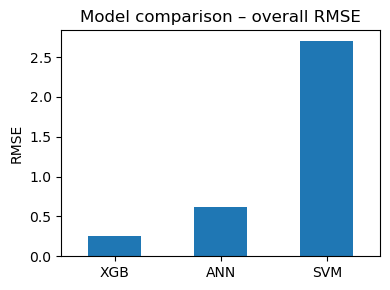

In [19]:
### Visual 3 – overall RMSE comparison  (CELL 7-bis)

overall.RMSE.plot.bar(rot=0, figsize=(4,3))
plt.ylabel("RMSE"); plt.title("Model comparison – overall RMSE")
plt.tight_layout(); plt.savefig(Path("../reports/figures/rmse_comparison.png"))
plt.show()

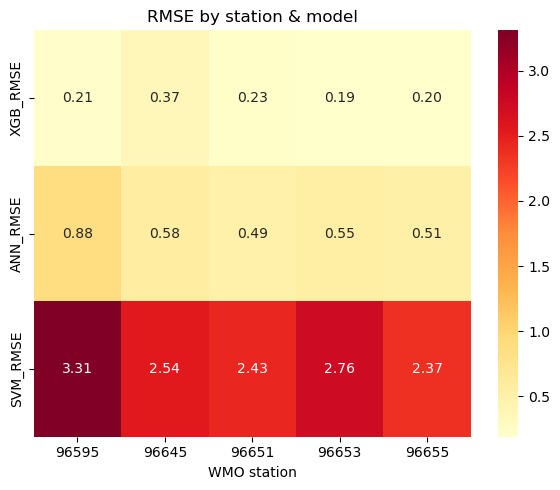

In [21]:
### Visual 4 – per-station RMSE heatmap  (CELL 8-bis)
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(per_station_all.filter(like="_RMSE").T,
            annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("RMSE by station & model"); plt.xlabel("WMO station"); plt.ylabel("")
plt.tight_layout()
plt.savefig(Path("../reports/figures/rmse_station_comparison.png"))
plt.show()


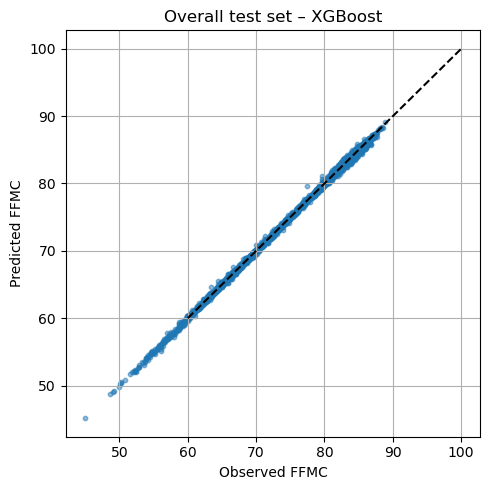

In [22]:
### Visual 1 – prediction vs observation scatter (CELL 7)
plt.figure(figsize=(5,5))
plt.scatter(test["ffmc"], test["pred"], s=10, alpha=0.5)
plt.plot([60,100], [60,100], "k--")
plt.xlabel("Observed FFMC"); plt.ylabel("Predicted FFMC")
plt.title("Overall test set – XGBoost")
plt.grid(True); plt.tight_layout()
plt.savefig(Path("../reports/figures/scatter_xgboost.png"))
plt.show()


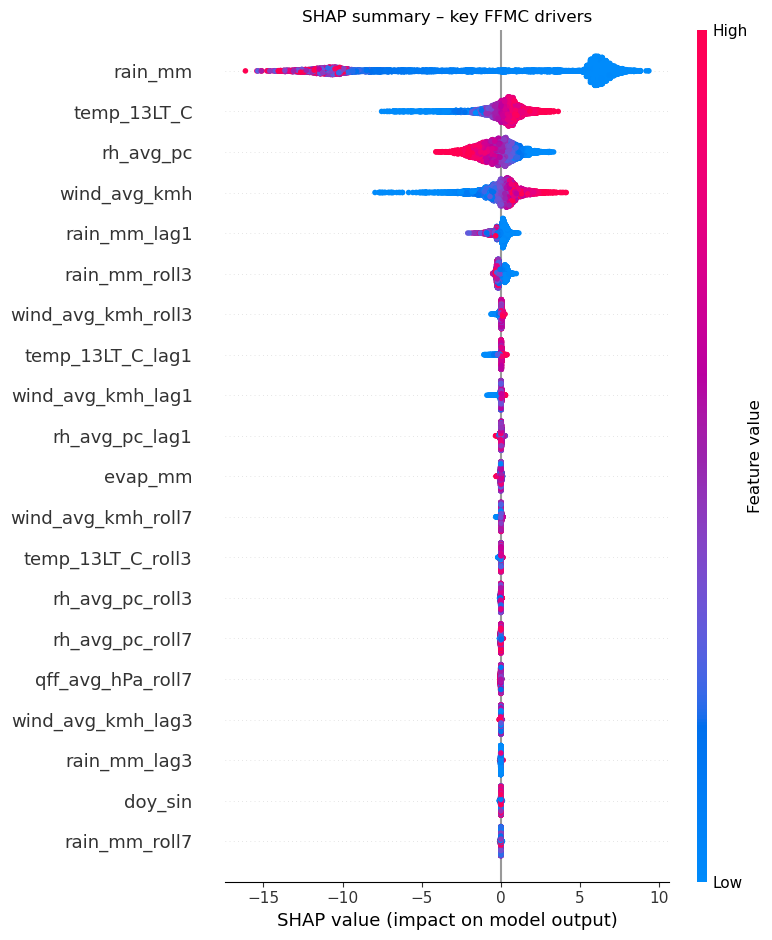

In [23]:
### RQ 2 – SHAP feature importance  (CELL 9)
import shap
sample = df.sample(6000, random_state=0)   # speed; adjust if GPU available
X_sample = sample[PRED_COLS]

explainer = shap.Explainer(best_model)
shap_values = explainer(X_sample, check_additivity=False)

shap.summary_plot(shap_values, X_sample, show=False)
plt.title("SHAP summary – key FFMC drivers")
plt.tight_layout()
plt.savefig(Path("../reports/figures/feature_xgboost.png"))
plt.show()
